In [1]:
import os
from pathlib import Path
os.chdir("/Users/oliverdaniels-koch/projects/elk-experiments")
out_dir = Path("output")

# Edge Attribution Patching Detector

In [2]:
import os
from pathlib import Path
import torch
from cupbearer import tasks, detectors, scripts, utils
from cupbearer.detectors import ActivationCache
from elk_experiments.utils import train_detector_cache

## Load Task

In [3]:
task = tasks.tiny_natural_mechanisms("hex", "mps", "pythia-70m")

Loaded pretrained model attn-only-1l into HookedTransformer
Moving model to device:  mps


/Users/oliverdaniels-koch/Library/Caches/pypoetry/virtualenvs/elk-experiments-AZ2LBS3Q-py3.10/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model pythia-70m into HookedTransformer
Moving model to device:  mps


In [4]:
from cupbearer.tasks.tiny_natural_mechanisms import TinyNaturalMechanismsDataset
def get_task_subset(task, train_subset, normal_test_subset, anomalous_test_subset):
    train_data = task.trusted_data.data[:train_subset]
    normal_test_data = task.test_data.normal_data.data[:normal_test_subset]
    anomalous_test_data = task.test_data.anomalous_data.data[:anomalous_test_subset]
    return tasks.Task.from_separate_data(
        model=task.model, 
        trusted_data=TinyNaturalMechanismsDataset(train_data),
        clean_test_data=TinyNaturalMechanismsDataset(normal_test_data), 
        anomalous_test_data=TinyNaturalMechanismsDataset(anomalous_test_data)
    )

## Mahanobis Baseline

In [5]:
save_path = out_dir / "pythia-70m-hex-atten-out-mahalanobis-detector"
cache_path = (save_path / "activation_cache").with_suffix(utils.SUFFIX)
if os.path.exists(cache_path):
    cache = ActivationCache.load(cache_path)
else:
    cache = ActivationCache()

In [6]:
# run malanabois on final layer final token
def get_activation_at_last_token(
    activation: torch.Tensor, inputs: list[list[int]], name: str
):
    if activation.ndim == 3:
        # Residual stream or equivalent, shape is (batch, seq, hidden)
        return activation[:, -1, :]
    elif activation.ndim == 4 and activation.shape[-1] == activation.shape[-2]:
        # Attention, shape is (batch, num_heads, query, key)
        # TODO: this could also be Q/K/V if n_heads happens to be head_dim
        return activation[:, :, -1, :].reshape(activation.shape[0], -1)
    elif activation.ndim == 4:
        # Query/key/value, shape is (batch, seq, num_heads, hidden)
        return activation[:, -1, :, :].reshape(activation.shape[0], -1)
    else:
        raise ValueError(f"Unexpected activation shape: {activation.shape}")

In [7]:
names = [
    # "hook_embed.output",
    # "blocks.0.hook_attn_out.output",
    "blocks.1.hook_attn_out.output",
    "blocks.2.hook_attn_out.output",
    "blocks.3.hook_attn_out.output",
    # "blocks.4.hook_resid_post.output"
    "blocks.4.hook_attn_out.output",
    # "blocks.5.hook_attn_out.output"
]

detector = detectors.MahalanobisDetector(
    names, layer_aggregation="mean", cache=cache, activation_processing_func=get_activation_at_last_token
)

2024-06-28 13:52:58.887 | INFO     | cupbearer.detectors.anomaly_detector:load_weights:261 - Loading detector from output/pythia-70m-hex-atten-out-mahalanobis-detector/detector.pth
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

2024-06-28 13:52:59.394 | INFO     | cupbearer.detectors.anomaly_detector:eval:152 - AUC_ROC (all): 0.9008
2024-06-28 13:52:59.394 | INFO     | cupbearer.detectors.anomaly_detector:eval:153 - AP (all): 0.8555


(defaultdict(dict,
             {'all': {'AUC_ROC': 0.9008159637451172,
               'AP': 0.8554785483428201}}),
 {'all': <Figure size 640x480 with 1 Axes>})

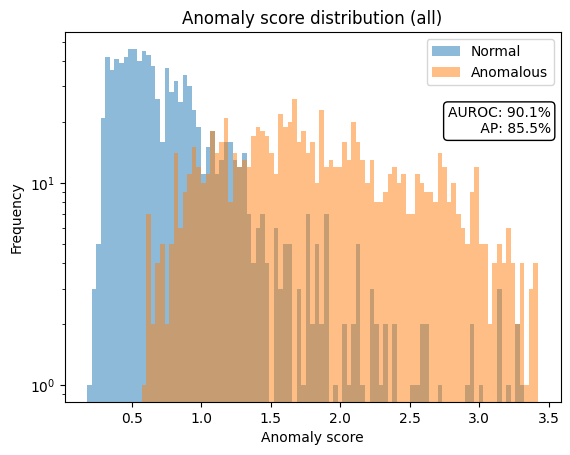

In [8]:
train_detector_cache(save_path, detector, task, batch_size=64, eval_batch_size=64, 
                     cache=cache, cache_path=cache_path, overwrite=False, overwrite_cache=False,run_eval_from_cached=True)

## Edge Attribution Abstract Detector

In [9]:
from eap.eap_wrapper import EAP

In [10]:
# TODO: look back at edge attribution example
task.model.set_use_split_qkv_input(True)
task.model.set_use_attn_result(True)
task.model.set_use_hook_mlp_in(True)

In [11]:
# use mean probability over effect tokens as metric 
def effect_prob_func(logits, effect_tokens):
    assert logits.ndim == 3
    # Sum over vocab and batch dim (for now we're just computing attribution values, we'll deal with per data instance later)
    probs = logits[:, -1, :].softmax(dim=-1)
    out = probs[:, effect_tokens].mean(dim=-1).mean() # mean over effect tokens, mean over batch
    # out = logits[:, -1, effect_tokens].mean()
    return out

In [12]:
from cupbearer.tasks.tiny_natural_mechanisms import get_effect_tokens
effect_tokens = get_effect_tokens("hex", task.model)

In [13]:
def not_first_layer(edge):
    return "0" != edge.split(".")[1]

In [14]:
#TODO: put in EAPGraph
def get_edge_scores_filter_indices(edge_filter, graph):
    valid_upstream_idxs = [i for (i, node) in enumerate(graph.upstream_nodes) if edge_filter(node)]
    valid_downstream_idxs = [i for (i, node) in enumerate(graph.downstream_nodes) if edge_filter(node)]
    uu, dd = torch.meshgrid(torch.tensor(valid_upstream_idxs), torch.tensor(valid_downstream_idxs), indexing='ij')
    return uu, dd

In [15]:
from abc import ABC
from functools import partial
from torch import Tensor
from cupbearer.detectors.statistical import StatisticalDetector, MahalanobisDetector
from eap.eap_wrapper import EAP_clean_forward_hook, EAP_clean_backward_hook
from eap.eap_graph import EAPGraph

from transformer_lens import HookedTransformer

class EAPDetector(StatisticalDetector, ABC):

    EAP_SCORES_NAME = "eap_scores"
    
    def __init__(
          self, 
          effect_prob_func, 
          upstream_nodes=["head", "mlp"], 
          downstream_nodes=["head", "mlp"],
          edge_filter=lambda x : True,
          seq_len=16, # would ideally pass on train and eval, but don't want to change script (shrug)
          **kwargs
    ):
        self.effect_prob_func = effect_prob_func
        self.upstream_nodes = upstream_nodes
        self.downstream_nodes = downstream_nodes
        self.edge_filter = edge_filter
        self.seq_len = seq_len 
        self.trusted_graph = None 
        self.untrusted_graphs = []
        super().__init__(
            activation_names=[self.EAP_SCORES_NAME], 
            activation_processing_func=lambda x: x,
            **kwargs
        )
    
    def set_model(self, model: HookedTransformer):
        super().set_model(model)
        self.graph = EAPGraph(model.cfg, self.upstream_nodes, self.downstream_nodes, aggregate_batch=False, verbose=False)
        self.uu, self.dd = get_edge_scores_filter_indices(self.edge_filter, self.graph)
    
    def _set_hooks(self, batch_size, seq_len):
        # import ipdb; ipdb.set_trace()
        self.upstream_activations_difference = torch.zeros(
            (batch_size, seq_len, self.graph.n_upstream_nodes, self.model.cfg.d_model),
            device=self.model.cfg.device,
            dtype=self.model.cfg.dtype,
            requires_grad=False
        )

        # set the EAP scores to zero
        self.graph.reset_scores(batch_size)

        self.upstream_hook_filter = lambda name: name.endswith(tuple(self.graph.upstream_hooks))
        self.downstream_hook_filter = lambda name: name.endswith(tuple(self.graph.downstream_hooks))

        self.clean_upstream_hook_fn = partial(
            EAP_clean_forward_hook,
            upstream_activations_difference=self.upstream_activations_difference,
            graph=self.graph
        )

        self.clean_downstream_hook_fn = partial(
            EAP_clean_backward_hook,
            upstream_activations_difference=self.upstream_activations_difference,
            graph=self.graph, 
            aggregate_batch=False
        )

    def _get_activations_no_cache(self, inputs) -> dict[str, Tensor]:
        with torch.enable_grad():
            inputs = utils.inputs_to_device(inputs, self.model.cfg.device)
            batch_size, seq_len = inputs.shape[:2]
            self.model.reset_hooks()
            self._set_hooks(batch_size, seq_len=seq_len)
            #TODO: add support for corrupted tokens
            self.model.add_hook(self.upstream_hook_filter, self.clean_upstream_hook_fn, "fwd")
            self.model.add_hook(self.downstream_hook_filter, self.clean_downstream_hook_fn, "bwd")

            value = self.effect_prob_func(self.model(inputs, return_type="logits"))
            value.backward()

            self.model.zero_grad()
            self.upstream_activations_difference *= 0
            return {self.EAP_SCORES_NAME: self.graph.eap_scores[:, self.uu, self.dd]}

In [16]:
class EAPMahalanobisDetector(EAPDetector, MahalanobisDetector):
    pass

In [17]:
from cupbearer.detectors import ActivationCache

In [18]:
save_path = Path("output/pythia-70m-hex-filtered-eap-detector")

In [19]:
cache_path = Path(save_path / "activation_cache").with_suffix(utils.SUFFIX)
if os.path.exists(cache_path):
    eap_cache = ActivationCache.load(cache_path)
else:
    eap_cache = ActivationCache()

In [20]:
detector = EAPMahalanobisDetector(
    effect_prob_func=partial(effect_prob_func, effect_tokens=effect_tokens),
    upstream_nodes=["head", "mlp"],
    downstream_nodes=["head", "mlp"],
    edge_filter=lambda x: True,#not_first_layer,
    seq_len=16,
    layer_aggregation="mean", 
    cache=eap_cache
)

In [21]:
train_detector_cache(
    save_path, detector, task, batch_size=64, eval_batch_size=64, cache=eap_cache, 
    cache_path=cache_path, overwrite=True, overwrite_cache=True, inference_mode=False
)

/Users/oliverdaniels-koch/Library/Caches/pypoetry/virtualenvs/elk-experiments-AZ2LBS3Q-py3.10/lib/python3.10/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
2024-06-28 13:53:05.503 | DEBUG    | cupbearer.detectors.statistical.statistical:init_variables:77 - Received multi-dimensional activations, will only learn covariances along last dimension and treat others independently. If this is unintentional, pass `activation_preprocessing_func=utils.flatten_last`.
2024-06-28 13:53:05.504 | DEBUG    | cupbearer.detectors.statistical.statistical:init_variables:83 - Activation sizes: 
eap_scores: torch.Size([54, 150])
  4%|▍         | 11/256